## 已知参数

In [1]:

import numpy as np
class Settings:
    """已知参数"""
    def __init__(self):
        self.H = 200
        self.D = 180
        self.e = 40
        self.K = 1.035
        self.conefficient_l_AC2 = 0.38
        self.Q1 = 140
        self.Q2 = 115
        self.Q3 = 190
        self.conefficient_Rho_square = 0.17
        self.n = 650
        self.Delta = 1 / 100
        self.u_pi = 2   # pi 的比例尺
        self.pi = np.array([
            0, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1.5, -5, -8, -15, -43.5, -140, -140, -72.5,
            -50.5, -32.5, -15, -7.5, -2.5, -2.5, -1, -1, -1, -1, -1, -1
        ])
        self.pi = self.u_pi * self.pi
        self.g = 10

## 求解机构的几何参数

方法如下：

![](pict/1.png)

In [2]:
import math

class Mechanism:
    """曲柄滑块机构的求解计算"""
    def __init__(self, mech_settings):
        self.K = mech_settings.K
        self.H = mech_settings.H
        self.e = mech_settings.e
        self.angle = 180 * (self.K - 1) / (self.K + 1)
        self.theta = math.radians(self.angle)
        self.l = 0
        self.r = 0
        self.__solve()

    def __solve(self):
        """return length and radians"""
        # 三角形圆的半径
        theta = self.theta
        H = self.H
        e = self.e
        R = H / (2 * math.sin(theta))

        CD = R * math.cos(theta)
        OE = math.sqrt(R**2 - (CD - e)**2)
        OF = OE + H / 2

        l_plus_r = math.sqrt(OF**2 + e**2)
        alpha = math.asin(OE / R)
        delta = alpha - theta
        l_minus_r = 2 * R * math.sin(delta / 2)

        self.l = (l_plus_r + l_minus_r) / 2
        self.r = (l_plus_r - l_minus_r) / 2


In [5]:
mech_settings = Settings()
crank_slider = Mechanism(mech_settings)


display("angle = {}".format(crank_slider.angle))
display("l = {}".format(crank_slider.l))
display("r = {}".format(crank_slider.r))

'angle = 3.0958230958230883'

'l = 397.52175616699924'

'r = 99.45807704268577'

## 解析计算

1. 采用状态的想法来划分
2. 将速度、加速度等作为子类来处理
3. 简洁处理，不需要传递参数的就不需要

### 计算坐标

#### 15 个坐标点

In [8]:
from func import tool
class Cood_param:
    """
    ## 计算坐标的关键参数

    主要的结果为 `角度`
    """
    def __init__(self):
        self.l_OB_up = crank_slider.r + crank_slider.l
        self.l_OB_down = abs( crank_slider.r - crank_slider.l)
        self.B_up = {'x': mech_settings.e, 'y': 0}
        self.B_down = {'x': mech_settings.e, 'y': 0}
        self.B_up['y'] = self.__calc_By(self.l_OB_up)
        self.B_down['y'] = self.__calc_By(self.l_OB_down)
        self.theta_list = []

        self.__calc_theta_list()
    
    def __calc_By(self, l):
        return (l**2 - mech_settings.e**2)**0.5
    
    def __calc_theta_list(self):
        theta0 = tool.xy_to_polar_theta(self.B_up['x'], self.B_up['y'])
        temp_theta_list = []
        # 角度相差 30 度
        delta_theta = math.pi / 6
        for i in range(0,12):
            temp_theta = theta0 - i * delta_theta
            temp_theta_list.append(temp_theta)
        # 加入 6' 点
        theta6 = tool.xy_to_polar_theta(self.B_down['x'], self.B_down['y']) - math.pi
        temp_theta_list.append(theta6)
        # 加入 2' 和 9'
        temp_l_OB = math.hypot(crank_slider.r, crank_slider.l)
        temp_By = self.__calc_By(temp_l_OB)
        theta_OB = tool.xy_to_polar_theta(mech_settings.e, temp_By)
        theta_OBA = tool.xy_to_polar_theta(crank_slider.r, crank_slider.l)
        theta_2_prime = theta_OB - theta_OBA
        # 首先确定角度, 然后减去 2 * pi ,使得排在第 9' 处
        theta_9_prime = theta_OB + theta_OBA - 2 * math.pi
        temp_theta_list.extend([theta_2_prime, theta_9_prime])
        temp_theta_list.sort(reverse=True)
        
        self.theta_list = temp_theta_list.copy()
        
cood_param = Cood_param()

# test
# display(cood_param.theta_list)

#### 根据角度,推算状态,画图

In [12]:
from func import graphic


class Coordinates:
    """
    # 坐标位置
    
    - **以O点建立坐标系**

    """
    def __init__(self, id_name, theta):
        self.A = {'x': 0, 'y': 0}
        self.B = {'x': mech_settings.e, 'y': 0}
        self.id_name = id_name
        self.theta_OA = theta
        self.l_OA = crank_slider.r
        self.l_AB = crank_slider.l

        self.__calc_pos_A()
        self.__calc_pos_B()

    def __calc_pos_A(self):
        self.A['x'] = self.l_OA * math.cos(self.theta_OA)
        self.A['y'] = self.l_OA * math.sin(self.theta_OA)

    def __calc_pos_B(self):
        self.B['y'] = self.A['y'] + (self.l_AB**2 -
                                     (self.B['x'] - self.A['x'])**2)**0.5

    def draw(self):
        fig_pos = graphic.Fig_position(cood_param, self.A, self.B,
                                       crank_slider.r)
        fig_pos.show(self.id_name)


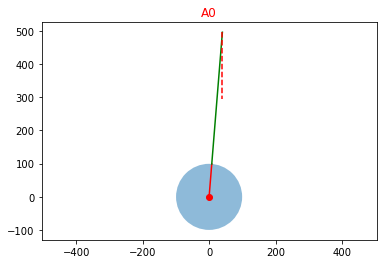

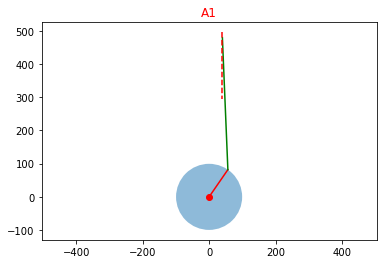

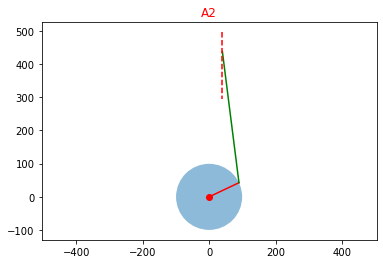

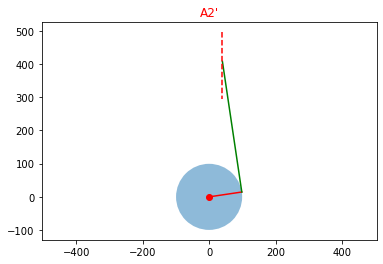

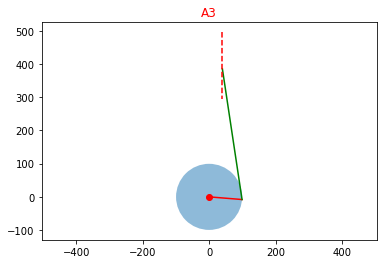

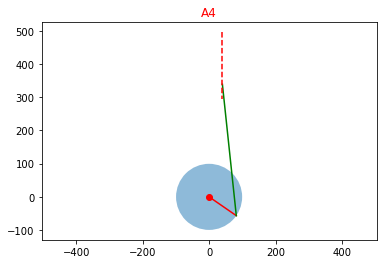

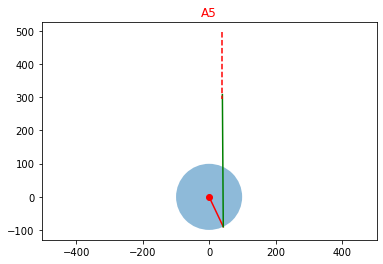

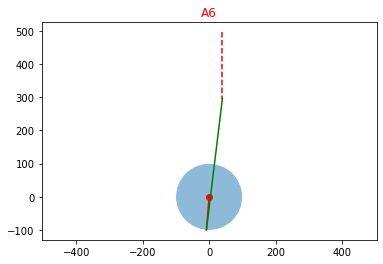

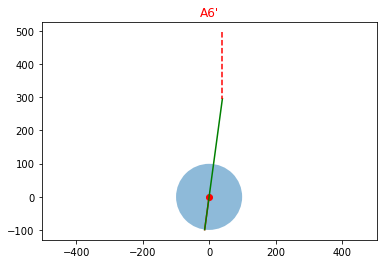

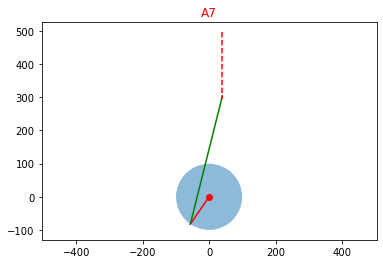

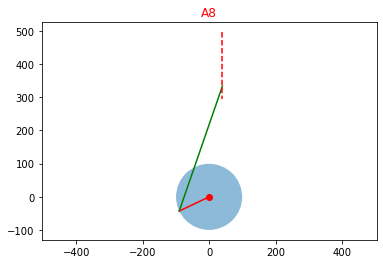

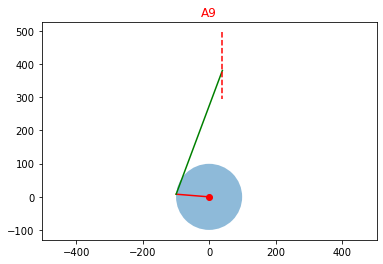

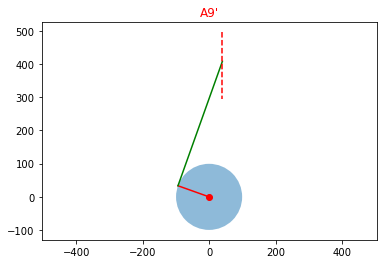

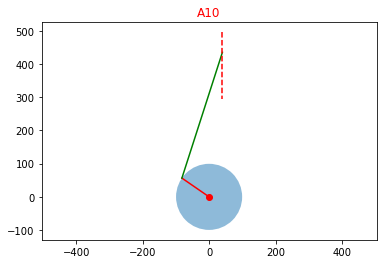

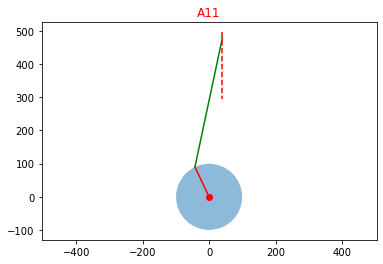

In [13]:
from func import test
cood_list = []

for theta, id_name in zip(cood_param.theta_list, test.name_list_2):
    cood = Coordinates(id_name, theta)
    cood.draw()
    cood_list.append(cood)


### 根据坐标,计算对应的速度